# Assignment 1: Data Curation

### Import Libraries

In [1]:
import json
import requests
import datetime
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

### Step 1: Data Acquisition

In order to measure Wikipedia traffic from 2008-2021, we are collecting data from two different API endpoints:

1. Legacy Pagecounts API : The Legacy Pagecounts API provides access to desktop and mobile traffic data from December 2007 through July 2016.


2. Pageviews API: The Pageviews API provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month.

In [2]:
# Endpoints
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

# Dates for Legacy data
start_date_legacy = datetime.datetime(2007, 12, 1)
end_date_legacy = datetime.datetime(2016, 8, 1)

# Dates for Pageviews data
start_date_pageviews = datetime.datetime(2015, 7, 1)
end_date_pageviews = datetime.datetime(2021, 10, 1)

headers = {
    'User-Agent': 'https://github.com/KrishaMehta98',
    'From': 'kkm98@gmail.com'
}

In [3]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [4]:
def date_format_api(date):
    return date.strftime("%Y%m%d%H")

def date_format_filename(date):
    return date.strftime("%Y%m")

In [5]:
# Collect Legacy data
access_sites = ["desktop-site","mobile-site"]
for access_site in access_sites:
    params_legacy = {"project" : "en.wikipedia.org",
                     "access-site" : access_site,
                     "granularity" : "monthly",
                     "start" : date_format_api(start_date_legacy),
                     "end" : date_format_api(end_date_legacy)}
        
    monthly_legacy = api_call(endpoint_legacy, params_legacy)
        
    # save the raw data in a .json file
    legacy_file_name = f'pagecounts_{access_site}_{date_format_filename(start_date_legacy)}-{date_format_filename(end_date_legacy)}.json'
    file_path = os.path.join('../data/source', legacy_file_name) 
    with open(file_path, 'w') as f:
        json.dump(monthly_legacy, f)

In [6]:
# Collect Pageviews data
accesses = ["desktop","mobile-app","mobile-web"]
for access in accesses:
    params_pageviews = {"project" : "en.wikipedia.org",
                        "access" : access,
                        "agent" : "user",
                        "granularity" : "monthly",
                        "start": date_format_api(start_date_pageviews),
                        "end" : date_format_api(end_date_pageviews)}
    
    monthly_pageviews = api_call(endpoint_pageviews, params_pageviews)
    
    # save the raw data in a .json file
    pageviews_file_name = f'pageviews_{access}_{date_format_filename(start_date_pageviews)}-{date_format_filename(end_date_pageviews)}.json'
    file_path = os.path.join('../data/source', pageviews_file_name) 
    with open(file_path, 'w') as f:
        json.dump(monthly_pageviews, f)

### Step 2: Data processing

We perform a series of processing steps on these data files in order to prepare them for analysis:

1. Read the raw data 


2. Combine monthly values of mobile-app and mobile-web to create a total mobile traffic count for each month


3. Seperate timestamp value to year and month


4. Output table with the following columns:
 - year
 - month
 - pagecount_all_views
 - pagecount_desktop_views
 - pagecount_mobile_views
 - pageview_all_views
 - pageview_desktop_views
 - pageview_mobile_views
 
 
5. Send data to file: en-wikipedia_traffic_200712-202108.csv


In [7]:
raw_files = os.listdir('../data/source')

In [8]:
# Read raw data into a single dataframe
df_list = []
for raw_file in raw_files:
    with open(os.path.join('../data/source', raw_file), 'r') as f:
        data = json.load(f)
        df = pd.json_normalize(data, record_path=['items'])
        df['Source'] = '_'.join(raw_file.split('_')[:2])
        df_list.append(df) 
df = pd.concat(df_list)

In [9]:
df['views'] = df['views'].fillna(df['count'])
df.drop(columns=['project', 'granularity', 'count', 'access-site', 'access', 'agent'], inplace=True)
df = pd.pivot_table(df, values='views', columns='Source', index=['timestamp']).reset_index()

In [10]:
# Timestamp to year and month
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

# Replacing NAs with 0 for addition
df.fillna({'pagecounts_desktop-site':0, 
           'pagecounts_mobile-site':0,
           'pageviews_desktop':0,
           'pageviews_mobile-app':0,
           'pageviews_mobile-web':0}, inplace=True)

# Calculations for all views
df['pageview_mobile_views'] = df['pageviews_mobile-app'] + df['pageviews_mobile-web']
df['pageview_all_views'] = df['pageview_mobile_views'] + df['pageviews_desktop']
df['pagecount_all_views'] = df['pagecounts_desktop-site'] + df['pagecounts_mobile-site']

# Columns renamed as per requirement
df.rename(columns={'pagecounts_desktop-site': 'pagecount_desktop_views', 
                   'pagecounts_mobile-site': 'pagecount_mobile_views',
                    'pageviews_desktop': 'pageview_desktop_views'}, inplace=True)

# Rearranging columns
df = df[['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]


In [11]:
df

Source,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,2008,1,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,2008,2,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,2008,3,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,2008,4,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
161,2021,5,0.000000e+00,0.000000e+00,0.0,7.800996e+09,2.824416e+09,4.976580e+09
162,2021,6,0.000000e+00,0.000000e+00,0.0,7.090482e+09,2.505971e+09,4.584510e+09
163,2021,7,0.000000e+00,0.000000e+00,0.0,7.544494e+09,2.765584e+09,4.778909e+09
164,2021,8,0.000000e+00,0.000000e+00,0.0,7.495608e+09,2.763414e+09,4.732194e+09


In [12]:
# Data sent to 'en-wikipedia_traffic_200712-202109.csv' file
processed_file_path = os.path.join('../data/final', 'en-wikipedia_traffic_200712-202109.csv')
df.to_csv(processed_file_path, index=False)

### Step 3: Analysis

We will visualize the dataset as a time series graph. The visualization will track three traffic metrics: mobile traffic, desktop traffic, and all traffic (mobile + desktop).

In [13]:
df.replace(0, np.nan, inplace=True)
df_dates = df['year'].map(str) + df['month'].map(str)
dates = pd.to_datetime(df_dates,format='%Y%m')

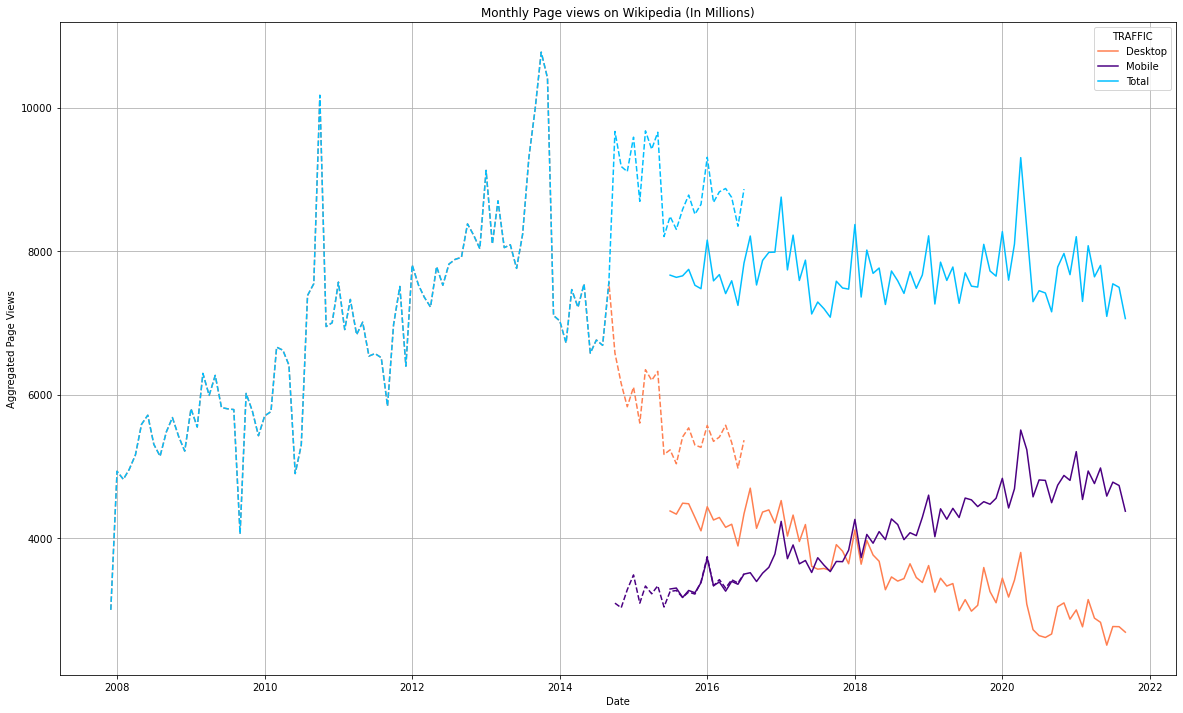

In [14]:
# Visualization

plt.figure(figsize=(20, 12))

plt.grid(True)
plt.plot(dates, df['pagecount_desktop_views']/1e6, color='coral', linestyle="--", label='')
plt.plot(dates, df['pagecount_mobile_views']/1e6, color='indigo', linestyle="--", label='')
plt.plot(dates, df['pagecount_all_views']/1e6, color='deepskyblue', linestyle="--", label='')

plt.plot(dates, df['pageview_desktop_views']/1e6, color='coral', label='Desktop')
plt.plot(dates, df['pageview_mobile_views']/1e6, color='indigo', label='Mobile')
plt.plot(dates, df['pageview_all_views']/1e6, color='deepskyblue', label='Total')

plt.xlabel('Date')
plt.ylabel('Aggregated Page Views')
plt.title('Monthly Page views on Wikipedia (In Millions)')

plt.legend(title='TRAFFIC')
plt.grid(True)

plt.savefig(os.path.join('../data/image','wikipedia_page_views_visualization.png'))
